# Planejamento da Solução

- Qual é o Entregável?

- Reportar ao Head de Design qual é a melhor forma de pagamento: Preenchimento Manual ou Automático do formulário de dados do cartão de crétito

- Quais dados nós temos

- uid: Id do Cliente 
- Country: País do Cliente
- Gender: Gênero do Cliente
- spent: Valor monetário que o Cliente gastou
- purchases: Quantidade de Compras 
- Date:

- Group: 
    - A: Preenchimento Automático
    - B: Preenchimento Manual

- Device:
    - I: Compra feita através do site 
    - A: Compra feita através do App

# Imports

In [60]:
import pandas as pd
import seaborn as sns
import math
import statsmodels.stats.weightstats as ws

from statsmodels.stats import api as sms



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Load

In [15]:
df = pd.read_csv('../data/ab_testing.csv')

# 1.0 Descrição dos Dados

In [16]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [17]:
df1.shape

(25230, 8)

## 1.2 Check Na

In [18]:
df1.isna().sum()

uid          0
country      1
gender       1
spent        1
purchases    1
date         1
group        1
device       1
dtype: int64

In [19]:
df1 = df1.dropna()

## 1.3 Data Types

In [20]:
df1.dtypes

uid            int64
country       object
gender        object
spent        float64
purchases    float64
date          object
group         object
device        object
dtype: object

## 1.4 Change Data Types

In [21]:
df1['date'] = pd.to_datetime(df1['date'])

# 2.0 EDA

In [57]:
df2 = df1.copy()

In [71]:
df2[['uid','group']].groupby('group').count().reset_index()

,group,uid
0,GRP A,12671
1,GRP B,12558


In [72]:
df2[['uid','device']].groupby('device').count().reset_index()

,device,uid
0,A,12586
1,I,12643


In [74]:
df2[['uid','country']].groupby('country').count().reset_index().sort_values('uid', ascending=False)

,country,uid
9,USA,7684
1,BRA,4917
7,MEX,2991
3,DEU,2073
8,TUR,1965
6,GBR,1606
5,FRA,1572
4,ESP,1057
2,CAN,821
0,AUS,543


## 2.1 Gastos por País

<Axes: xlabel='country', ylabel='spent'>

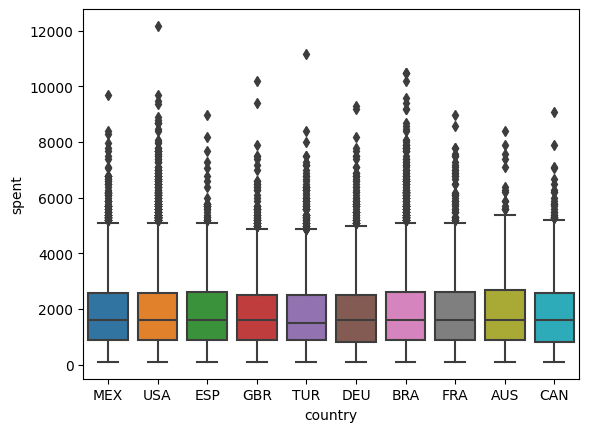

In [61]:
# Gasto por País
sns.boxplot(x=df2['country'], y=df2['spent'])


## 2.2 Gastos por Gênero

<Axes: xlabel='gender', ylabel='spent'>

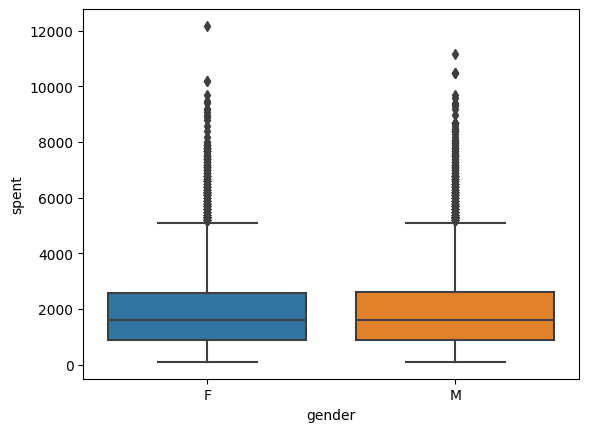

In [62]:
# Gasto por Gênero
sns.boxplot(x=df2['gender'], y=df2['spent'])


## 2.3 Gastos por Device

<Axes: xlabel='device', ylabel='spent'>

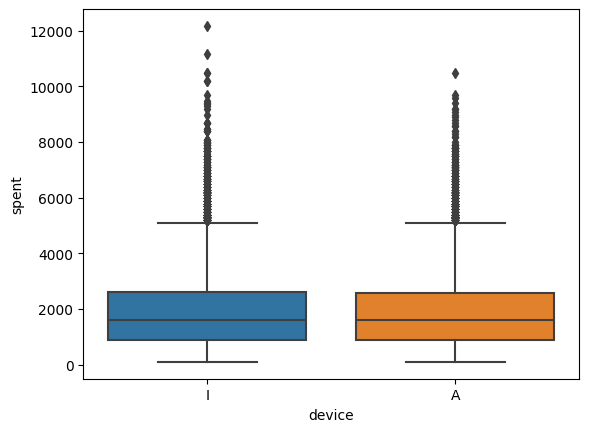

In [63]:
# Gasto por Device
sns.boxplot(x=df2['device'], y=df2['spent'])


## 2.4 Gastos por Dia

<Axes: xlabel='date', ylabel='spent'>

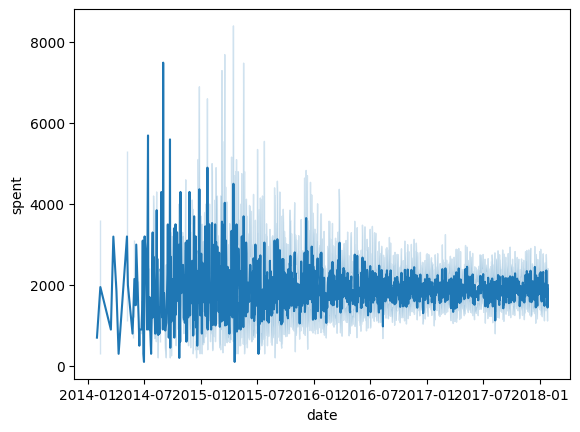

In [64]:
# Gastos por dia
sns.lineplot(x='date', y='spent', data=df2)

## 2.5 Gastos por Dia por Grupos

<Axes: xlabel='date', ylabel='spent'>

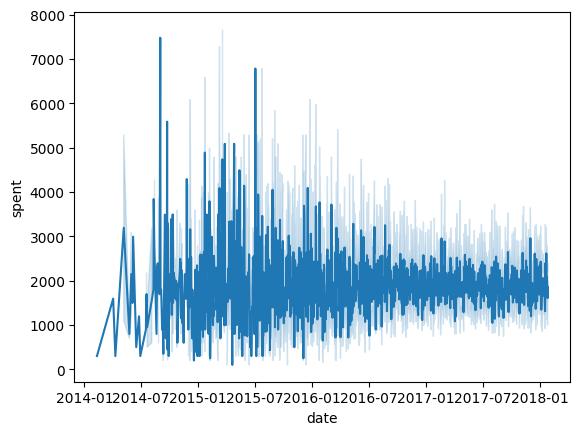

In [65]:
# Gastos por dia da página nova
sns.lineplot(x='date', y='spent', data=df2[df2['group'] == 'GRP A'])

<Axes: xlabel='date', ylabel='spent'>

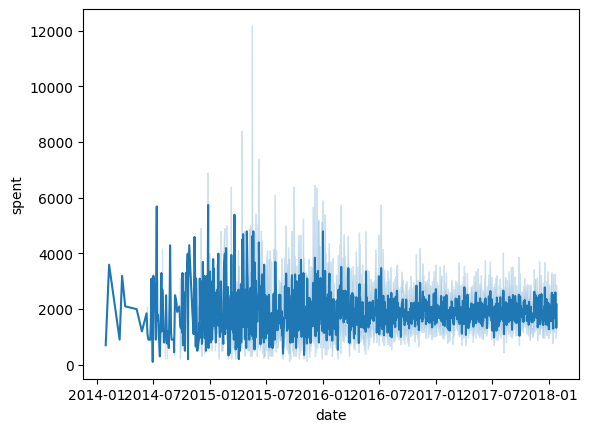

In [66]:
# Gastos por dia da página atual
sns.lineplot(x='date', y='spent', data=df2[df2['group'] == 'GRP B'])

## 2.6 Gastos por Grupos

<Axes: xlabel='group', ylabel='spent'>

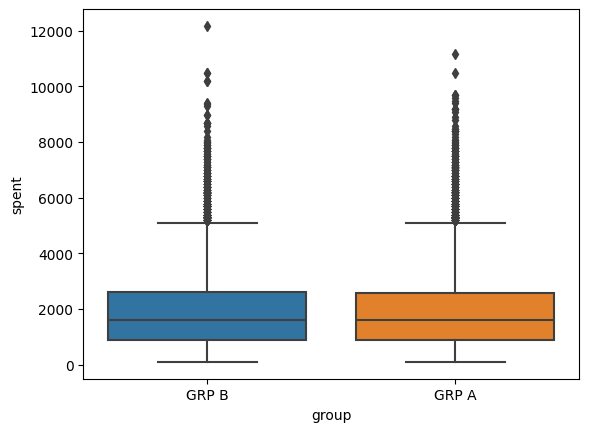

In [67]:
sns.boxplot(x=df2['group'], y=df2['spent'])